In [ ]:
from flask import Flask, request, jsonify
from keras.models import load_model
import numpy as np
from PIL import Image
import io

# Initialize Flask app
app = Flask(__name__)

# Load your trained model inside Jupyter
model_path = r"G:\DermaAI\DermaAI [Code]\src\backend\models\efficientnet_lite0_skin_disease_model.h5"
model = load_model(model_path, compile=False)

# Preprocessing function for images
def preprocess_image(image):
    image = image.resize((224, 224))  # Resize to model input size
    image = np.array(image) / 255.0   # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file uploaded'}), 400

    file = request.files['file']
    image = Image.open(io.BytesIO(file.read()))
    processed_image = preprocess_image(image)

    try:
        prediction = model.predict(processed_image)
        confidence = float(np.max(prediction)) * 100  # Get highest confidence score
        labels = ["Normal", "Disease"]  # Modify based on your model's classes
        predicted_class = labels[np.argmax(prediction)]

        return jsonify({'prediction': predicted_class, 'confidence': confidence})

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(port=5000, debug=True)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './models/efficientnet_lite0_skin_disease_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### workingcode

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow_hub as hub
import tensorflow as tf

# Step 1: Define Paths
BASE_DIR = r"D:\FYP project\IMG_CLASSES_SPLIT"
train_dir = os.path.join(BASE_DIR, "train")
validation_dir = os.path.join(BASE_DIR, "validation")

# Step 2: Extract Disease Categories
categories = sorted(os.listdir(train_dir))
print("Categories:", categories)

# Function to create a data dictionary
def data_dictionary(data_dir, categories):
    data_dict = {"image_path": [], "target": []}
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        image_list = os.listdir(category_path)
        for img_name in image_list:
            img_path = os.path.join(category_path, img_name)
            data_dict["image_path"].append(img_path)
            data_dict["target"].append(idx)
    return pd.DataFrame(data_dict)

# Create dataframes for train and validation datasets
train_df = data_dictionary(train_dir, categories)
validation_df = data_dictionary(validation_dir, categories)

# Step 3: Preprocess Images
def process_images(df):
    images = []
    labels = []
    for img_path, target in zip(df["image_path"], df["target"]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # EfficientNet-Lite0 expects 224x224 inputs
        images.append(img)
        labels.append(target)
    return np.array(images), np.array(labels)

train_images, train_labels = process_images(train_df)
val_images, val_labels = process_images(validation_df)

# Normalize Images
train_images = train_images / 255.0  # Normalize to [0, 1] range
val_images = val_images / 255.0

# Step 4: EfficientNet-Lite0 Model using TensorFlow Hub
# Use EfficientNet-Lite0 feature vector model
efficientnet_lite0_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"

# Wrap the KerasLayer in a Lambda to ensure compatibility
def load_feature_extractor():
    base_model = hub.KerasLayer(efficientnet_lite0_url, trainable=False)
    return base_model

feature_extractor = Lambda(lambda x: load_feature_extractor()(x))

# Define input layer
inputs = Input(shape=(224, 224, 3))
feature_vector = feature_extractor(inputs)

# Add custom classification layers
x = BatchNormalization()(feature_vector)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(categories), activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Convert labels to categorical (one-hot encoding)
train_labels_categorical = tf.keras.utils.to_categorical(train_labels, len(categories))
val_labels_categorical = tf.keras.utils.to_categorical(val_labels, len(categories))

# Step 5: Callbacks
checkpoint = ModelCheckpoint('efficientnet_lite0_skin_disease_best.keras', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Step 6: Training
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Step 7: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_images, val_labels_categorical)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Save the model
model.save('efficientnet_lite0_skin_disease_model.h5')

# Step 8: Plot Training and Validation Metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


ModuleNotFoundError: No module named 'tensorflow_hub'

103/103 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/step


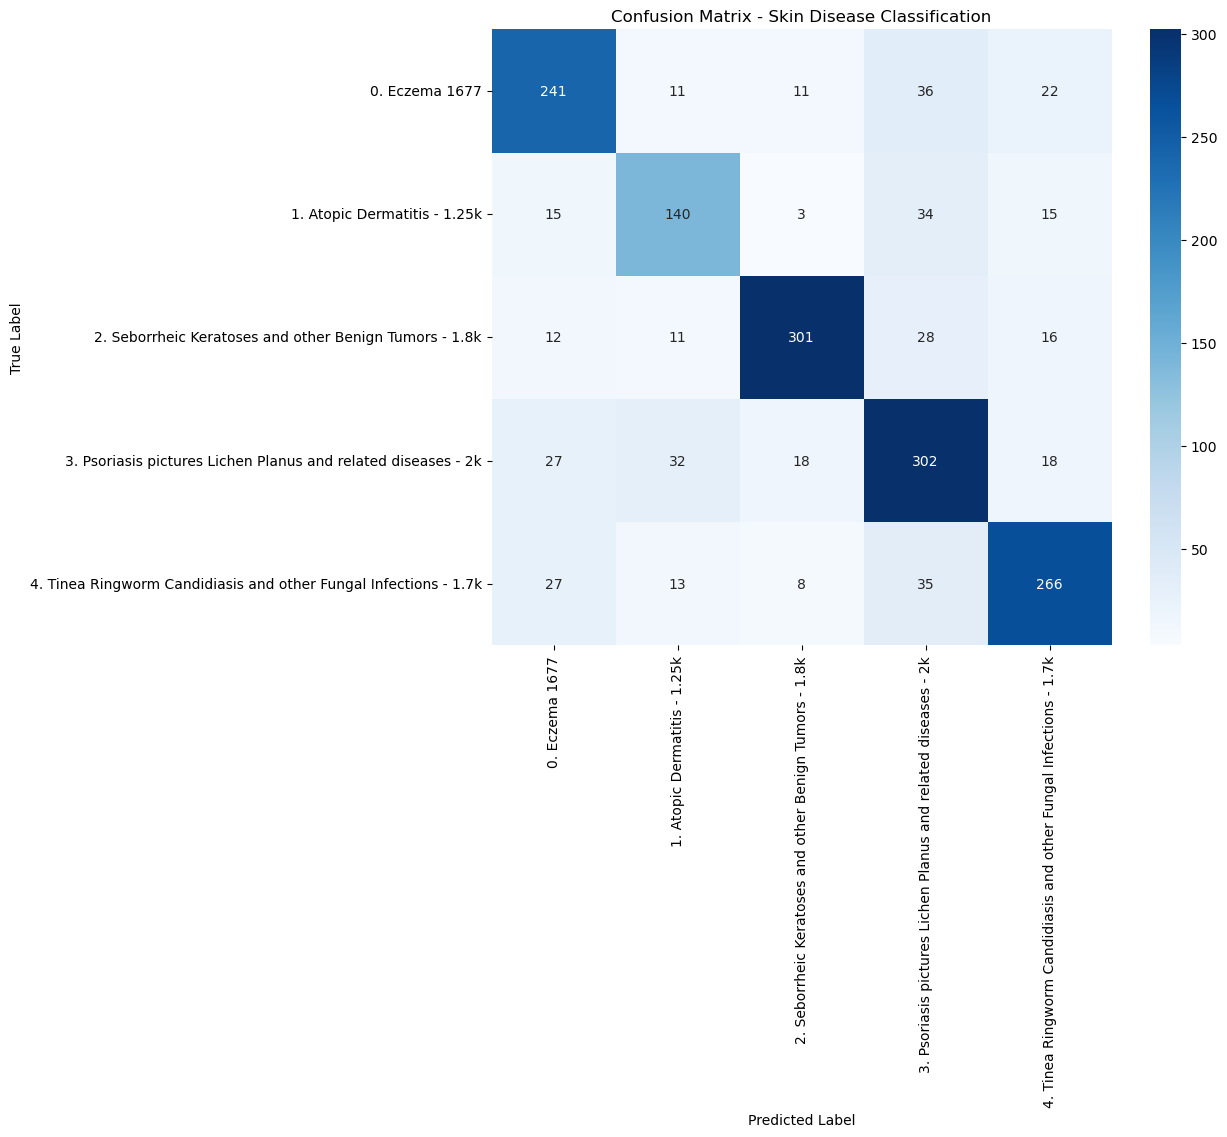

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Step 1: Get predictions on the validation data
y_pred = model.predict(val_images, batch_size=16, verbose=1)

# Step 2: Convert predicted probabilities to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Step 3: Convert true labels from one-hot encoding to class labels
y_true = np.argmax(val_labels_categorical, axis=1)

# Step 4: Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Skin Disease Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Get predictions on the validation data
y_pred = model.predict(val_images, batch_size=16, verbose=1)

# Step 2: Convert predicted probabilities to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Step 3: Convert true labels from one-hot encoding to class labels
y_true = np.argmax(val_labels_categorical, axis=1)

# Step 4: Calculate the classification report
class_report = classification_report(y_true, y_pred_class, target_names=categories)

# Step 5: Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_class)

# Print the classification report
print("Classification Report:\n", class_report)

# Print the accuracy score
print(f"Accuracy: {accuracy * 100:.2f}%")


103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 322ms/step
Classification Report:
                                                                   precision    recall  f1-score   support

                                                  0. Eczema 1677       0.75      0.75      0.75       321
                                    1. Atopic Dermatitis - 1.25k       0.68      0.68      0.68       207
          2. Seborrheic Keratoses and other Benign Tumors - 1.8k       0.88      0.82      0.85       368
   3. Psoriasis pictures Lichen Planus and related diseases - 2k       0.69      0.76      0.73       397
4. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k       0.79      0.76      0.78       349

                                                        accuracy                           0.76      1642
                                                       macro avg       0.76      0.75      0.76      1642
                                                    weighted avg       0.77      0

In [ ]:
import tkinter as tk
from tkinter import filedialog, Label, Button
from PIL import Image, ImageTk
import numpy as np
import cv2
from tensorflow.keras.models import load_model

from keras.models import load_model
import tensorflow as tf

# Custom function used in Lambda layer
def custom_lambda_function(x):
    return x * 2  # Replace with your Lambda logic

# Load the model
model = load_model(
    "efficientnet_lite0_skin_disease_model.h5",
    custom_objects={"custom_lambda_function": custom_lambda_function}
)
# Define categories (replace with actual category names)
categories = ['0. Eczema 1677', '1. Atopic Dermatitis - 1.25k', '2. Seborrheic Keratoses and other Benign Tumors - 1.8k', '3. Psoriasis pictures Lichen Planus and related diseases - 2k', '4. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']

# Function to preprocess the image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to handle image upload and prediction
def upload_and_predict():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
    if not file_path:
        return
    
    # Display the uploaded image
    img = Image.open(file_path)
    img = img.resize((300, 300))
    img_tk = ImageTk.PhotoImage(img)
    image_label.config(image=img_tk)
    image_label.image = img_tk


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer_4>',)
  • kwargs={'mask': 'None'}

In [ ]:
# Import EfficientNetB0 from TensorFlow Keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Load EfficientNetB0 with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the base model layers to retain pre-trained features
base_model.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Adjust output layer for your number of categories
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint('efficientnet_skin_disease_best.keras', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Convert labels to categorical (one-hot encoding)
train_labels_categorical = to_categorical(train_labels, len(categories))
val_labels_categorical = to_categorical(val_labels, len(categories))

# Train the model
history = model.fit(
    train_images, train_labels_categorical,
    validation_data=(val_images, val_labels_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_images, val_labels_categorical)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save the model
model.save('efficientnet_skin_disease_model.h5')

# Plot Training Accuracy and Loss
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "efficientnetb0" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
%matplotlib inline

In [ ]:
# Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 2: Define Paths
BASE_DIR = r"D:\FYP project\IMG_CLASSES_SPLIT"
train_dir = os.path.join(BASE_DIR, "train")
validation_dir = os.path.join(BASE_DIR, "validation")

In [ ]:
# Step 3: Extract Disease Categories
categories = sorted(os.listdir(train_dir))
print("Categories:", categories)

Categories: ['0. Eczema 1677', '1. Atopic Dermatitis - 1.25k', '2. Seborrheic Keratoses and other Benign Tumors - 1.8k', '3. Psoriasis pictures Lichen Planus and related diseases - 2k', '4. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


In [ ]:
# Function to create a data dictionary
def data_dictionary(data_dir, categories):
    data_dict = {"image_path": [], "target": []}
    for idx, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        image_list = os.listdir(category_path)
        for img_name in image_list:
            img_path = os.path.join(category_path, img_name)
            data_dict["image_path"].append(img_path)
            data_dict["target"].append(idx)
    return pd.DataFrame(data_dict)


In [ ]:
# Create dataframes for train and validation datasets
train_df = data_dictionary(train_dir, categories)
validation_df = data_dictionary(validation_dir, categories)


In [ ]:
# Step 4: Preprocess Images
def process_images(df):
    images = []
    labels = []
    for img_path, target in zip(df["image_path"], df["target"]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (180, 180))
        images.append(img)
        labels.append(target)
    return np.array(images), np.array(labels)

train_images, train_labels = process_images(train_df)
val_images, val_labels = process_images(validation_df)


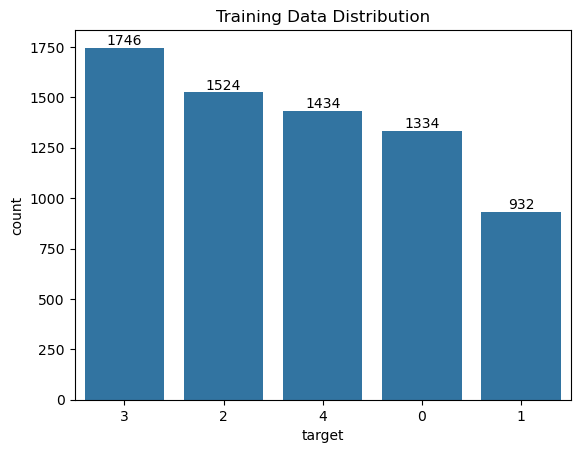

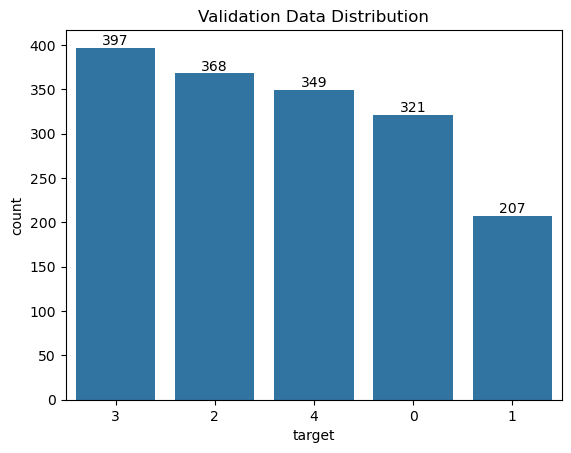

In [ ]:
# Visualize data distribution
def plot_data_distribution(df, title):
    ax = sns.countplot(x=df["target"], order=df["target"].value_counts(ascending=False).index)
    abs_values = df["target"].value_counts(ascending=False).values
    ax.bar_label(container=ax.containers[0], labels=abs_values)
    plt.title(title)
    plt.show()

plot_data_distribution(train_df, "Training Data Distribution")
plot_data_distribution(validation_df, "Validation Data Distribution")


In [ ]:
# Step 5: Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment training data
train_images_augmented = data_gen.flow(train_images, train_labels, batch_size=32)


In [ ]:
# Step 6: EfficientNetB0 Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Output layer for multi-class classification
])


In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Step 7: Initialize Model Variables
_ = model(np.zeros((1, 180, 180, 3)))


In [ ]:
# Step 8: Callbacks
checkpoint = ModelCheckpoint('efficientnet_skin_disease_best.keras', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [ ]:
# Step 9: Training
history = model.fit(
    train_images_augmented,
    validation_data=(val_images, val_labels_categorical),
    epochs=20,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/20


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 5)

In [ ]:
# Step 10: Evaluate the Model
val_loss, val_accuracy = model.evaluate(val_images, val_labels_categorical)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


52/52 ━━━━━━━━━━━━━━━━━━━━ 36s 681ms/step - accuracy: 0.6794 - loss: 0.9112
Validation Accuracy: 69.31%


In [ ]:
# Save the model
model.save('efficientnet_skin_disease_model.h5')

# Step 11: Plot Training and Validation Metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.figure(figsize=(12, 4))


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

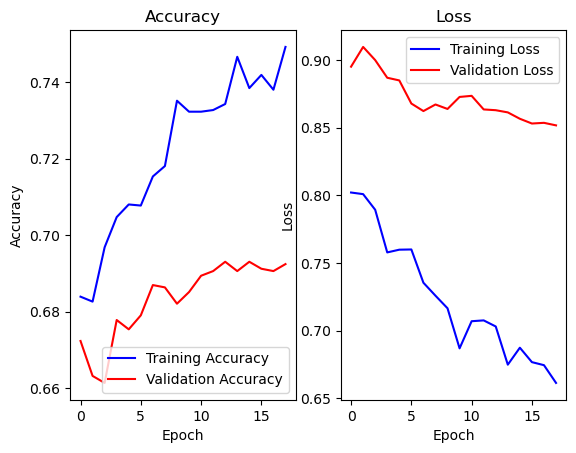

In [ ]:
# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

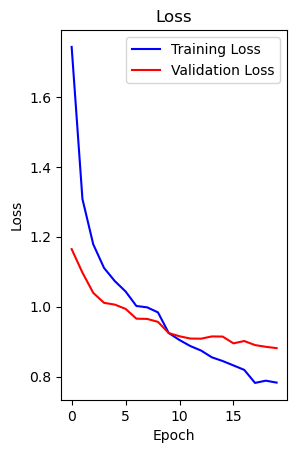